# Baysian Graph Neural Networks for Band Gap predcitions 

### imports 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import ast
from pymatgen.core import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN
from torch_geometric.data import Data
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from GBNN_model import BayesianGCN
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import trange
from pyro.infer import Predictive
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch_geometric.utils import to_networkx
import networkx as nx
from pymatgen.core import Element
from sklearn.preprocessing import StandardScaler




In [2]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/mp_data_100k_cleaned2.csv')

In [3]:
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,0,99994,10,Sr1 Cr1 H1 O2,SrCrHO2,116.010397,"{'crystal_system': 'Tetragonal', 'symbol': 'P4...",mp-1218324,"{'@module': 'pymatgen.core.structure', '@class...",-2.090215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,28876,12,Sc1 I1 O1,ScIO,279.252151,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-559760,"{'@module': 'pymatgen.core.structure', '@class...",-2.891759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,41418,40,Ga3 Bi5 Cl12,Ga3Bi5Cl12,1302.857133,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-569854,"{'@module': 'pymatgen.core.structure', '@class...",-1.229581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,41414,10,Ag1 N1 O3,AgNO3,125.104504,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-552185,"{'@module': 'pymatgen.core.structure', '@class...",-0.680664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,28883,24,Tl1 Cr3 O8,TlCr3O8,361.671041,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561221,"{'@module': 'pymatgen.core.structure', '@class...",-1.778230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_mp["structure"][0]

"{'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[4.010959, -2e-06, 3.605534999999999], [4.010959, 2e-06, -3.605534999999999], [0.0, 4.010968, -3.605537]], 'pbc': [True, True, True], 'a': 5.393299058638413, 'b': 5.393299058638413, 'c': 5.39330708891984, 'alpha': 63.45372175240732, 'beta': 116.54627824759268, 'gamma': 83.90607221672619, 'volume': 116.01039743935735}, 'properties': {}, 'sites': [{'species': [{'element': 'Sr', 'occu': 1}], 'abc': [0.749997999999999, 0.75, 0.5], 'properties': {'magmom': -0.0}, 'label': 'Sr', 'xyz': [6.016430478081996, 2.005484000004, -1.8027757110700036]}, {'species': [{'element': 'Sr', 'occu': 1}], 'abc': [0.249998, 0.250001, 0.499998999999999], 'properties': {'magmom': -0.0}, 'label': 'Sr', 'xyz': [2.005475489041, 2.005479989037996, -1.8027757110679965]}, {'species': [{'element': 'Cr', 'occu': 1}], 'abc': [0.500012999999999, 0.499992999999999, 1.6000000000000003e-05], 'properties': {'magmom': -2.922}, 'la

In [5]:
# Example for one row
structure_str = df_mp.loc[4, "structure"]
structure = Structure.from_dict(ast.literal_eval(structure_str))


In [6]:
print(structure)

Full Formula (Tl2 Cr6 O16)
Reduced Formula: TlCr3O8
abc   :   5.086271   5.086448  15.515907
angles:  94.743198  94.739149  64.870076
pbc   :       True       True       True
Sites (24)
  #  SP            a          b         c    magmom
---  ----  ---------  ---------  --------  --------
  0  Tl     0.999712  -0.00055   5e-06       -0.003
  1  Tl     0.000558   0.000114  0.499998    -0.003
  2  Cr    -0.000144   0.000134  0.750003     2.646
  3  Cr     0.000109  -5.7e-05   0.24999      2.647
  4  Cr     0.375574   0.375429  0.350601     0.199
  5  Cr     0.375275   0.375581  0.850631     0.2
  6  Cr     0.624703   0.62443   0.149402     0.2
  7  Cr     0.624423   0.624623  0.649387     0.2
  8  O      0.223883   0.223652  0.277197    -0.053
  9  O      0.223462   0.223797  0.777245    -0.053
 10  O      0.776507   0.776184  0.222778    -0.053
 11  O      0.776195   0.776464  0.722763    -0.053
 12  O      0.323356   0.323444  0.447523     0.006
 13  O      0.323154   0.323564  0.94757

In [7]:
def get_atom_features(atomic_number: int) -> torch.Tensor:
    try:
        elem = Element.from_Z(atomic_number)

        # One-hot encoding for periodic block
        block_dict = {"s": 0, "p": 1, "d": 2, "f": 3}
        block_vec = [0.0] * 4
        if elem.block in block_dict:
            block_vec[block_dict[elem.block]] = 1.0

        features = [
            atomic_number,
            elem.group or 0,
            elem.row or 0,
            elem.atomic_mass or 0,
            elem.atomic_radius or 0,
            elem.electronegativity or 0,
            elem.mendeleev_no or 0,
            elem.nvalence or 0,
            elem.van_der_waals_radius or 0,
            elem.X or 0,
            elem.covalent_radius or 0,
            elem.thermal_conductivity or 0,
            elem.melting_point or 0,
            elem.boiling_point or 0,
            elem.density or 0,
            float(elem.is_metal),  # 1.0 if metal, else 0.0
        ] + block_vec

    except:
        features = [0.0] * (16 + 4)  # 16 features + 4 block one-hot

    return torch.tensor(features, dtype=torch.float32)


In [8]:
def structure_to_graph(structure):
    try:
        atomic_numbers = [site.specie.number for site in structure.sites]
        x = torch.stack([get_atom_features(Z) for Z in atomic_numbers])

        sgraph = StructureGraph.from_local_env_strategy(structure, CrystalNN())
        edge_index = []
        edge_attr = []

        for i, j, attrs in sgraph.graph.edges(data=True):
            edge_index.append((i, j))

            # Distance as edge feature
            dist = structure.get_distance(i, j)
            edge_attr.append([dist])

        edge_index = torch.tensor(edge_index, dtype=torch.long).T
        edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    except Exception as e:
        print(f"structure_to_graph failed: {e}")
        return None

#### Convert structures from MP data into graphs

In [9]:
""" 
# Construct graph list from MP data
graph_data_list = []
for i, row in df_mp.iterrows():
    try:
        structure = Structure.from_dict(ast.literal_eval(row["structure"]))
        graph = structure_to_graph(structure)
        if graph is not None:
            graph.y = torch.tensor([row["band_gap"]], dtype=torch.float32)
            graph_data_list.append(graph)
    except Exception as e:
        print(f"Skipping row {i}: {e}")
""" 

' \n# Construct graph list from MP data\ngraph_data_list = []\nfor i, row in df_mp.iterrows():\n    try:\n        structure = Structure.from_dict(ast.literal_eval(row["structure"]))\n        graph = structure_to_graph(structure)\n        if graph is not None:\n            graph.y = torch.tensor([row["band_gap"]], dtype=torch.float32)\n            graph_data_list.append(graph)\n    except Exception as e:\n        print(f"Skipping row {i}: {e}")\n'

In [10]:

#torch.save(graph_data_list, "bandgap_graph_dataset_featurized2.pt")

In [11]:
import torch
from torch_geometric.data import Data
import torch.serialization

# Whitelist the known safe class
torch.serialization.add_safe_globals([Data])

# Now safely load
graph_data_list = torch.load("bandgap_graph_dataset_featurized2.pt", weights_only=False)


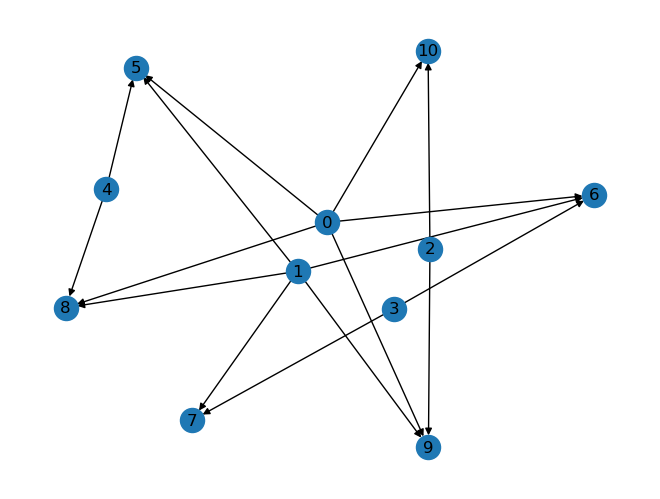

In [27]:
g = to_networkx(graph_data_list[11])
nx.draw(g, with_labels=True)
plt.show()

In [13]:
for data in graph_data_list:
    if data.y.ndim > 1:
        data.y = data.y.mean(dim=0, keepdim=True)
    else:
        data.y = data.y.mean().unsqueeze(0)

print(f"Example graph y shape: {graph_data_list[0].y.shape}")  # should be torch.Size([1])

Example graph y shape: torch.Size([1])


In [14]:
print(graph_data_list[4])

Data(x=[24, 20], edge_index=[2, 36], edge_attr=[36, 1], y=[1])


In [15]:


# Normalize node features
all_features = torch.cat([g.x for g in graph_data_list], dim=0)
scaler = StandardScaler().fit(all_features)

for graph in graph_data_list:
    graph.x = torch.tensor(scaler.transform(graph.x), dtype=torch.float32)


#### Train-test split 

In [16]:
from sklearn.preprocessing import StandardScaler

# Normalize node features
all_node_features = torch.cat([data.x for data in graph_data_list], dim=0).numpy()
scaler_X = StandardScaler().fit(all_node_features)
for data in graph_data_list:
    data.x = torch.tensor(scaler_X.transform(data.x.numpy()), dtype=torch.float32)

# Normalize target values (y)
all_targets = torch.cat([data.y for data in graph_data_list], dim=0).numpy().reshape(-1, 1)
scaler_y = StandardScaler().fit(all_targets)

for data in graph_data_list:
    data.y = torch.tensor(scaler_y.transform(data.y.reshape(-1, 1)), dtype=torch.float32)

In [17]:
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [18]:
for batch in train_loader:
    print(f"batch.x.shape: {batch.x.shape}")
    print(f"batch.batch.shape: {batch.batch.shape}")
    print(f"Number of graphs in batch: {batch.num_graphs}")
    break

batch.x.shape: torch.Size([1056, 20])
batch.batch.shape: torch.Size([1056])
Number of graphs in batch: 32


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [20]:
model = BayesianGCN(in_channels=graph_data_list[0].num_node_features, hidden_channels=64, out_channels=1)
batch = next(iter(train_loader)).to(device)
model(batch)      # should print: mu torch.Size([32]) sigma torch.Size([32]) y torch.Size([32])
pyro.clear_param_store()
guide = AutoDiagonalNormal(model)                      # now valid thanks to priors
optimizer = Adam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())



In [21]:

num_epochs = 100
loss_history = []

train_losses = []
val_losses = []

for epoch in trange(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        epoch_loss += svi.step(batch)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_loss += svi.evaluate_loss(batch)

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")



  1%|          | 1/100 [00:07<12:48,  7.76s/it]

Epoch 1, Train Loss: 904.4488, Val Loss: 756.6678


  2%|▏         | 2/100 [00:17<14:58,  9.17s/it]

Epoch 2, Train Loss: 712.5123, Val Loss: 624.1837


  3%|▎         | 3/100 [00:27<15:29,  9.58s/it]

Epoch 3, Train Loss: 607.2059, Val Loss: 546.4294


  4%|▍         | 4/100 [00:36<14:45,  9.22s/it]

Epoch 4, Train Loss: 536.6977, Val Loss: 483.1711


  5%|▌         | 5/100 [00:45<14:20,  9.05s/it]

Epoch 5, Train Loss: 476.1962, Val Loss: 434.8757


  6%|▌         | 6/100 [00:53<13:39,  8.72s/it]

Epoch 6, Train Loss: 426.8462, Val Loss: 386.5302


  7%|▋         | 7/100 [01:01<12:59,  8.38s/it]

Epoch 7, Train Loss: 385.9631, Val Loss: 348.6448


  8%|▊         | 8/100 [01:08<12:26,  8.12s/it]

Epoch 8, Train Loss: 346.9031, Val Loss: 315.1281


  9%|▉         | 9/100 [01:16<12:02,  7.94s/it]

Epoch 9, Train Loss: 313.7741, Val Loss: 282.4679


 10%|█         | 10/100 [01:25<12:38,  8.43s/it]

Epoch 10, Train Loss: 285.0889, Val Loss: 257.0010


 11%|█         | 11/100 [01:34<12:27,  8.39s/it]

Epoch 11, Train Loss: 261.9155, Val Loss: 234.7488


 12%|█▏        | 12/100 [01:42<12:28,  8.51s/it]

Epoch 12, Train Loss: 242.1961, Val Loss: 216.4854


 13%|█▎        | 13/100 [01:51<12:12,  8.42s/it]

Epoch 13, Train Loss: 225.0930, Val Loss: 202.0047


 14%|█▍        | 14/100 [01:59<12:05,  8.44s/it]

Epoch 14, Train Loss: 211.6310, Val Loss: 193.4446


 15%|█▌        | 15/100 [02:08<12:08,  8.57s/it]

Epoch 15, Train Loss: 202.1660, Val Loss: 184.3230


 16%|█▌        | 16/100 [02:18<12:45,  9.12s/it]

Epoch 16, Train Loss: 197.3374, Val Loss: 181.1371


 17%|█▋        | 17/100 [02:27<12:13,  8.84s/it]

Epoch 17, Train Loss: 190.2159, Val Loss: 174.3442


 18%|█▊        | 18/100 [02:35<12:02,  8.81s/it]

Epoch 18, Train Loss: 187.9467, Val Loss: 172.0578


 19%|█▉        | 19/100 [02:44<11:56,  8.84s/it]

Epoch 19, Train Loss: 184.9048, Val Loss: 169.9543


 20%|██        | 20/100 [02:52<11:33,  8.67s/it]

Epoch 20, Train Loss: 183.4565, Val Loss: 169.0042


 21%|██        | 21/100 [03:03<11:57,  9.09s/it]

Epoch 21, Train Loss: 181.8189, Val Loss: 168.5921


 22%|██▏       | 22/100 [03:11<11:37,  8.94s/it]

Epoch 22, Train Loss: 181.3158, Val Loss: 166.9239


 23%|██▎       | 23/100 [03:20<11:30,  8.96s/it]

Epoch 23, Train Loss: 180.9022, Val Loss: 166.5450


 24%|██▍       | 24/100 [03:29<11:16,  8.90s/it]

Epoch 24, Train Loss: 179.3992, Val Loss: 166.0027


 25%|██▌       | 25/100 [03:38<11:01,  8.82s/it]

Epoch 25, Train Loss: 179.7024, Val Loss: 171.7812


 26%|██▌       | 26/100 [03:45<10:26,  8.47s/it]

Epoch 26, Train Loss: 178.9492, Val Loss: 165.8589


 27%|██▋       | 27/100 [03:55<10:43,  8.82s/it]

Epoch 27, Train Loss: 179.5200, Val Loss: 166.0102


 28%|██▊       | 28/100 [04:03<10:14,  8.53s/it]

Epoch 28, Train Loss: 178.2149, Val Loss: 164.7189


 29%|██▉       | 29/100 [04:10<09:43,  8.21s/it]

Epoch 29, Train Loss: 178.4661, Val Loss: 165.8050


 30%|███       | 30/100 [04:19<09:41,  8.31s/it]

Epoch 30, Train Loss: 178.2065, Val Loss: 164.8985


 31%|███       | 31/100 [04:27<09:36,  8.35s/it]

Epoch 31, Train Loss: 178.3413, Val Loss: 163.9492


 32%|███▏      | 32/100 [04:38<10:10,  8.98s/it]

Epoch 32, Train Loss: 177.8578, Val Loss: 164.8253


 33%|███▎      | 33/100 [04:46<09:47,  8.76s/it]

Epoch 33, Train Loss: 179.7904, Val Loss: 163.9563


 34%|███▍      | 34/100 [04:53<09:13,  8.38s/it]

Epoch 34, Train Loss: 178.3215, Val Loss: 164.8196


 35%|███▌      | 35/100 [05:00<08:40,  8.00s/it]

Epoch 35, Train Loss: 178.1609, Val Loss: 165.7810


 36%|███▌      | 36/100 [05:07<08:13,  7.71s/it]

Epoch 36, Train Loss: 177.9596, Val Loss: 165.3293


 37%|███▋      | 37/100 [05:15<07:53,  7.51s/it]

Epoch 37, Train Loss: 177.8249, Val Loss: 164.1391


 38%|███▊      | 38/100 [05:22<07:37,  7.37s/it]

Epoch 38, Train Loss: 177.9537, Val Loss: 165.5992


 39%|███▉      | 39/100 [05:29<07:27,  7.33s/it]

Epoch 39, Train Loss: 177.4719, Val Loss: 164.7355


 40%|████      | 40/100 [05:36<07:22,  7.38s/it]

Epoch 40, Train Loss: 177.5021, Val Loss: 164.0889


 41%|████      | 41/100 [05:43<07:09,  7.29s/it]

Epoch 41, Train Loss: 177.8944, Val Loss: 164.5961


 42%|████▏     | 42/100 [05:50<06:59,  7.24s/it]

Epoch 42, Train Loss: 177.7447, Val Loss: 164.2400


 43%|████▎     | 43/100 [05:58<06:50,  7.20s/it]

Epoch 43, Train Loss: 177.2553, Val Loss: 164.0105


 44%|████▍     | 44/100 [06:05<06:40,  7.15s/it]

Epoch 44, Train Loss: 178.0668, Val Loss: 164.8643


 45%|████▌     | 45/100 [06:14<07:12,  7.87s/it]

Epoch 45, Train Loss: 177.8223, Val Loss: 164.4226


 46%|████▌     | 46/100 [06:22<07:07,  7.91s/it]

Epoch 46, Train Loss: 177.4360, Val Loss: 164.5049


 47%|████▋     | 47/100 [06:29<06:48,  7.71s/it]

Epoch 47, Train Loss: 177.4048, Val Loss: 164.6194


 48%|████▊     | 48/100 [06:37<06:37,  7.64s/it]

Epoch 48, Train Loss: 177.9029, Val Loss: 164.8928


 49%|████▉     | 49/100 [06:44<06:22,  7.50s/it]

Epoch 49, Train Loss: 178.4051, Val Loss: 164.3770


 50%|█████     | 50/100 [06:51<06:07,  7.35s/it]

Epoch 50, Train Loss: 177.5150, Val Loss: 165.1398


 51%|█████     | 51/100 [06:58<05:57,  7.30s/it]

Epoch 51, Train Loss: 177.6053, Val Loss: 163.4414


 52%|█████▏    | 52/100 [07:05<05:46,  7.22s/it]

Epoch 52, Train Loss: 177.6186, Val Loss: 163.8407


 53%|█████▎    | 53/100 [07:12<05:35,  7.15s/it]

Epoch 53, Train Loss: 177.5166, Val Loss: 164.3021


 54%|█████▍    | 54/100 [07:19<05:27,  7.12s/it]

Epoch 54, Train Loss: 178.0496, Val Loss: 164.0728


 55%|█████▌    | 55/100 [07:26<05:19,  7.11s/it]

Epoch 55, Train Loss: 177.6911, Val Loss: 164.1890


 56%|█████▌    | 56/100 [07:34<05:14,  7.14s/it]

Epoch 56, Train Loss: 177.4863, Val Loss: 163.8589


 57%|█████▋    | 57/100 [07:41<05:14,  7.32s/it]

Epoch 57, Train Loss: 177.2976, Val Loss: 164.3339


 58%|█████▊    | 58/100 [07:53<05:56,  8.48s/it]

Epoch 58, Train Loss: 177.3664, Val Loss: 164.0324


 59%|█████▉    | 59/100 [08:04<06:18,  9.22s/it]

Epoch 59, Train Loss: 177.7403, Val Loss: 164.8941


 60%|██████    | 60/100 [08:15<06:36,  9.90s/it]

Epoch 60, Train Loss: 177.3215, Val Loss: 164.2641


 61%|██████    | 61/100 [08:26<06:44, 10.37s/it]

Epoch 61, Train Loss: 177.6452, Val Loss: 164.5055


 62%|██████▏   | 62/100 [08:38<06:43, 10.63s/it]

Epoch 62, Train Loss: 177.7908, Val Loss: 164.0871


 63%|██████▎   | 63/100 [08:49<06:39, 10.81s/it]

Epoch 63, Train Loss: 177.8656, Val Loss: 165.3136


 64%|██████▍   | 64/100 [09:00<06:30, 10.85s/it]

Epoch 64, Train Loss: 177.6166, Val Loss: 164.1595


 65%|██████▌   | 65/100 [09:11<06:19, 10.83s/it]

Epoch 65, Train Loss: 177.6371, Val Loss: 163.9172


 66%|██████▌   | 66/100 [09:22<06:09, 10.85s/it]

Epoch 66, Train Loss: 177.3706, Val Loss: 165.3996


 67%|██████▋   | 67/100 [09:33<06:00, 10.91s/it]

Epoch 67, Train Loss: 177.1732, Val Loss: 164.3975


 68%|██████▊   | 68/100 [09:43<05:44, 10.77s/it]

Epoch 68, Train Loss: 177.6017, Val Loss: 164.0650


 69%|██████▉   | 69/100 [09:54<05:32, 10.73s/it]

Epoch 69, Train Loss: 177.8754, Val Loss: 164.8195


 70%|███████   | 70/100 [10:06<05:35, 11.18s/it]

Epoch 70, Train Loss: 177.7828, Val Loss: 164.3349


 71%|███████   | 71/100 [10:19<05:39, 11.69s/it]

Epoch 71, Train Loss: 177.4519, Val Loss: 164.2822


 72%|███████▏  | 72/100 [10:33<05:47, 12.40s/it]

Epoch 72, Train Loss: 177.4850, Val Loss: 164.3869


 73%|███████▎  | 73/100 [10:46<05:38, 12.53s/it]

Epoch 73, Train Loss: 177.2990, Val Loss: 164.2307


 74%|███████▍  | 74/100 [10:58<05:23, 12.44s/it]

Epoch 74, Train Loss: 178.0879, Val Loss: 164.0783


 75%|███████▌  | 75/100 [11:10<05:09, 12.36s/it]

Epoch 75, Train Loss: 177.7037, Val Loss: 164.0900


 76%|███████▌  | 76/100 [11:22<04:54, 12.26s/it]

Epoch 76, Train Loss: 177.4975, Val Loss: 164.6229


 77%|███████▋  | 77/100 [11:36<04:53, 12.76s/it]

Epoch 77, Train Loss: 177.5129, Val Loss: 164.3238


 78%|███████▊  | 78/100 [11:51<04:54, 13.37s/it]

Epoch 78, Train Loss: 177.5322, Val Loss: 164.7293


 79%|███████▉  | 79/100 [12:08<05:07, 14.63s/it]

Epoch 79, Train Loss: 177.5947, Val Loss: 164.6848


 80%|████████  | 80/100 [12:21<04:41, 14.07s/it]

Epoch 80, Train Loss: 177.2274, Val Loss: 164.4285


 81%|████████  | 81/100 [12:35<04:26, 14.02s/it]

Epoch 81, Train Loss: 177.6410, Val Loss: 164.3980


 82%|████████▏ | 82/100 [12:52<04:26, 14.79s/it]

Epoch 82, Train Loss: 177.7050, Val Loss: 163.9995


 83%|████████▎ | 83/100 [13:04<03:56, 13.93s/it]

Epoch 83, Train Loss: 177.2023, Val Loss: 164.6229


 84%|████████▍ | 84/100 [13:19<03:47, 14.25s/it]

Epoch 84, Train Loss: 177.4200, Val Loss: 164.4619


 85%|████████▌ | 85/100 [13:34<03:41, 14.75s/it]

Epoch 85, Train Loss: 177.5974, Val Loss: 164.4578


 86%|████████▌ | 86/100 [13:48<03:22, 14.49s/it]

Epoch 86, Train Loss: 177.5695, Val Loss: 164.6531


 87%|████████▋ | 87/100 [14:00<02:55, 13.48s/it]

Epoch 87, Train Loss: 177.7212, Val Loss: 164.3699


 88%|████████▊ | 88/100 [14:11<02:34, 12.87s/it]

Epoch 88, Train Loss: 177.8000, Val Loss: 164.2767


 89%|████████▉ | 89/100 [14:22<02:15, 12.36s/it]

Epoch 89, Train Loss: 177.4722, Val Loss: 164.1627


 90%|█████████ | 90/100 [14:34<02:01, 12.12s/it]

Epoch 90, Train Loss: 177.4532, Val Loss: 163.9544


 91%|█████████ | 91/100 [14:45<01:46, 11.85s/it]

Epoch 91, Train Loss: 177.3059, Val Loss: 164.6900


 92%|█████████▏| 92/100 [14:56<01:33, 11.69s/it]

Epoch 92, Train Loss: 177.7977, Val Loss: 164.6640


 93%|█████████▎| 93/100 [15:07<01:19, 11.32s/it]

Epoch 93, Train Loss: 177.5670, Val Loss: 163.5803


 94%|█████████▍| 94/100 [15:18<01:08, 11.38s/it]

Epoch 94, Train Loss: 177.4568, Val Loss: 164.2133


 95%|█████████▌| 95/100 [15:29<00:56, 11.30s/it]

Epoch 95, Train Loss: 177.3312, Val Loss: 164.2392


 96%|█████████▌| 96/100 [15:40<00:44, 11.22s/it]

Epoch 96, Train Loss: 177.5059, Val Loss: 164.9708


 97%|█████████▋| 97/100 [15:52<00:33, 11.23s/it]

Epoch 97, Train Loss: 177.4915, Val Loss: 164.4155


 98%|█████████▊| 98/100 [16:02<00:22, 11.07s/it]

Epoch 98, Train Loss: 177.6925, Val Loss: 164.3063


 99%|█████████▉| 99/100 [16:15<00:11, 11.58s/it]

Epoch 99, Train Loss: 177.6670, Val Loss: 163.7089


100%|██████████| 100/100 [16:26<00:00,  9.86s/it]

Epoch 100, Train Loss: 177.5526, Val Loss: 164.0654


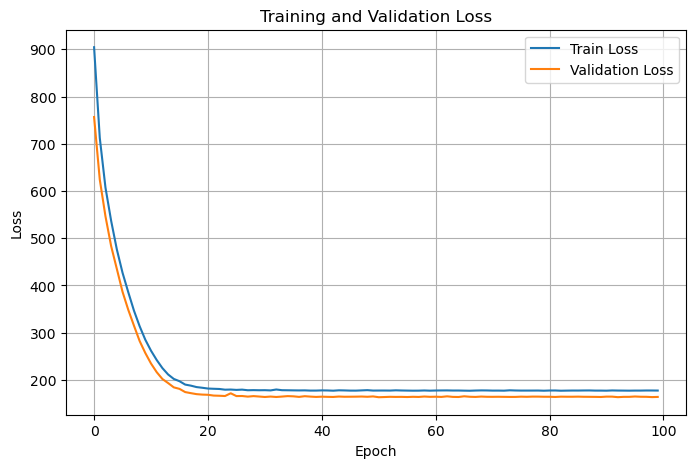

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Predict bandgaps and uncertainity 

In [25]:
# ───────────────────────────────────────────────────────
# draw more than one posterior sample
predictive = Predictive(
    model, guide=guide,
    num_samples=100,              # e.g. 100 Monte-Carlo draws
    return_sites=("mu_det",)      # make sure "mu_det" exists in the model/guide
)

all_means, all_stds, all_true = [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        y_saved, batch.y = batch.y, None      # break leakage

        
        mu_samples = predictive(batch)["mu_det"]   # [S, B]  (S = 100)
        # ---- mean over samples, then FLATTEN ----
        all_means.append(mu_samples.mean(0).reshape(-1).cpu())
        all_stds .append(mu_samples.std (0).reshape(-1).cpu())
        all_true .append(y_saved.reshape(-1).cpu())

# Concatenate
mean_pred = torch.cat(all_means).numpy()
std_pred  = torch.cat(all_stds ).numpy()
y_true    = torch.cat(all_true ).numpy()

# De-normalise
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
y_true_actual    = scaler_y.inverse_transform(y_true.reshape(-1, 1)).ravel()

# If you used StandardScaler, scale std’s too:
# std_pred_actual = std_pred * scaler_y.scale_
std_pred_actual = std_pred        # keep as-is for min-max scaling

# Evaluation
print("R²  :", r2_score(y_true_actual, mean_pred_actual))
print("MAE :", mean_absolute_error(y_true_actual, mean_pred_actual))
print("RMSE:", np.sqrt(mean_squared_error(y_true_actual, mean_pred_actual)))


R²  : -0.0005431175231933594
MAE : 1.220267415046692
RMSE: 1.520917872687679


#### Plot predictions and uncertainity


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('True Band Gap (eV)')
    plt.ylabel('Predicted Band Gap (eV)')
    plt.title('Prediction vs True Band Gap')
    plt.grid(True)
    plt.show()

plot_predictions(y_true_actual, mean_pred_actual)

In [ ]:
# Scatter plot: predicted vs true
plt.figure(figsize=(6, 6))
plt.scatter(y_true, mean_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')

plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("Predicted vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
def plot_uncertainty(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Uncertainty Prediction (±σ)", file_name=None
):
    # Compute CI bounds
    lower = y_pred - y_std
    upper = y_pred + y_std

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Begin plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='Prediction ±σ')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers (optional)
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index")
    plt.ylabel("Band Gap (eV)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


In [ ]:
# Identify outliers (optional)
error = np.abs(mean_pred_actual - y_true_actual)
outlier_mask = error > 0.5  # Customize your own threshold

# Plot
plot_uncertainty(
    x=np.arange(len(y_true_actual)),
    y_true=y_true_actual,
    y_pred=mean_pred_actual,
    y_std=std_pred_actual,
    outlier_mask=outlier_mask,
    title="Bayesian GCN Prediction ±σ"
)
